In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from collections import Counter,defaultdict
import re
import operator
import time
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

C:\Users\bodap\Anaconda2\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_csv('./formatted_ufo_reports.csv',names=['Date_obs', 'Day', 'Month',
       'Year', 'Time', 'Date_Posted', 'Day_Posted', 'Month_Posted',
       'Year_Posted', 'City', 'State', 'Country', 'Shape', 'Time_mins',
       'Time_text', 'Experiences', 'Lattitude', 'Longitude']);


C:\Users\bodap\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,2,4,5,6,9,10,11,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
class sentence_generator():
    def __init__(self,list_of_sent):
       self.list_of_sent=list_of_sent;
    def __iter__(self):    
       for sent in self.list_of_sent:
           sent=sent.lower();
           sent=re.sub('[^A-Za-z]',' ',sent);
           yield sent.split()

sentences=sentence_generator(df.Experiences);
start=time.time()
model=gensim.models.Word2Vec(sentences,min_count=1,size=50,workers=4)
print('Time elapsed: ',time.time()-start)
model.save('word_vectors_50_2.wv')

('Time elapsed: ', 27.630000114440918)


In [78]:
start=time.time()

model=gensim.models.Word2Vec.load('word_vectors_50_2.wv')
print('time elapsed: ',time.time() - start)
print model.most_similar(positive=['round','light'],negative=['bright'],topn=2)
print model.similarity('orange','red')




def sumup(sentence):
    sentence=sentence.lower()
    sentence=re.sub('[^A-Za-z]',' ' ,sentence)
    sentrep=np.zeros((1,50),dtype=float);
    for word in sentence.split():
        try:
           sentrep+=model[word]
        except:
           pass 
    return sentrep
    
    

('time elapsed: ', 0.9100000858306885)
[('lights', 0.6236444711685181), ('circle', 0.618617057800293)]
0.522986593296


In [80]:
keys=vocab.keys();
count=[];

sim1=[]
dist1=[];
sim2=[]
dist2=[];
sim3=[]
dist3=[];
sim4=[]
dist4=[];
sim5=[]
dist5=[];

for key in keys:
 #   print('Key:',key)
    count.append(vocab[key]);
 #   print(model.most_similar_cosmul(positive=[key],topn=5))
    sims=model.most_similar_cosmul(positive=[key],topn=5);
    sim1.append(sims[0][0])
    dist1.append(sims[0][1])
    sim2.append(sims[1][0])
    dist2.append(sims[1][1])
    sim3.append(sims[2][0])
    dist3.append(sims[2][1])
    sim4.append(sims[3][0])
    dist4.append(sims[3][1])
    sim5.append(sims[4][0])
    dist5.append(sims[4][1])

dictionary={'Word': keys,
            'Count':count,
            'Sim1': sim1,
            'Dist1':dist1,
            'Sim2':sim2,
            'Dist2':dist2,
            'Sim3':sim3,
            'Dist3':dist3,
            'Sim4':sim4,
            'Dist4':dist4,
            'Sim5':sim5,
            'Dist5':dist5
};

df2=pd.DataFrame(dictionary);
df2.to_csv('words_counts_similarity.csv');




In [81]:
inertia=[];
sent_rep=np.zeros((len(df),50),dtype=float);
for idx,sent in enumerate(df.Experiences):
    sent_rep[idx]=sumup(sent);
    #print sent_rep[idx]


('k= ', 1)
('inertia= ', 229836347.27985859)
('k= ', 2)
('inertia= ', 161127303.17547166)
('k= ', 3)
('inertia= ', 137946179.24489501)
('k= ', 4)
('inertia= ', 128309728.54292257)


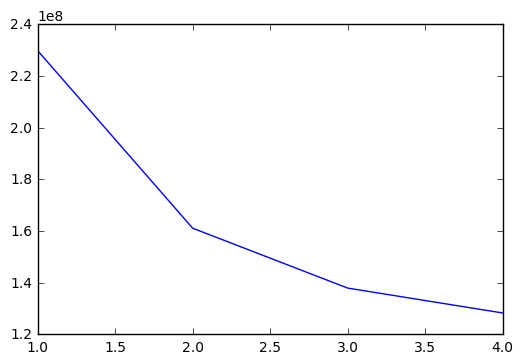

In [54]:
#print sent_rep[:2,:]
inertia=[]
for k in range(1,5):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(sent_rep)
    inertia.append(kmeans.inertia_);
    print("k= ",k)
    print("inertia= ",kmeans.inertia_) 
    
plt.plot(range(1,5),inertia)
plt.show()

In [82]:
k=2
kmeans=KMeans(n_clusters=k)
kmeans.fit(sent_rep)

label=kmeans.labels_
centroids=kmeans.cluster_centers_

tsne=TSNE(n_components=2)

sent_rep_picked=[];

rp=500

for i in range(k):
    sent_label=sent_rep[np.where(label==i)]
    if(sent_label.shape[0]>rp):
      random_pts=np.random.randint(0,sent_label.shape[0],rp)
      for pt in random_pts:
          sent_rep_picked.append(sent_label[pt]);
    else:
      for pt in range(sent_label.shape[0]):
          sent_rep_picked.append(sent_label[pt]);          
     
sent_rep_2D=tsne.fit_transform(sent_rep_picked)
centroids_2D=tsne.fit_transform(centroids)

   

[[ -1.95383986e-05  -1.16965230e-04]
 [ -1.13603523e-04   8.32372420e-05]]


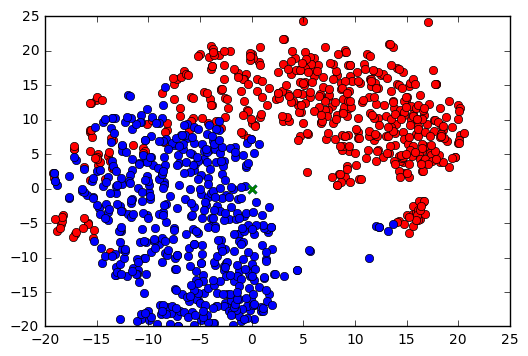

In [83]:
labels=[0]*rp ;
labels =labels+[1]*rp
#print sent_rep_2D
labels=np.array(labels,dtype=int)
colors=["red","blue"]

print centroids_2D

for i in range(k):
    d=sent_rep_2D[np.where(labels==i)]
    point_x=[ds[0] for ds in d]
    point_y=[ds[1] for ds in d]

    plt.plot(point_x,point_y,'o',c=colors[i])
    
    lines=plt.plot(centroids_2D[i,0],centroids_2D[i,1],'x')
    #plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=2.0)
plt.show() 

In [84]:
point_x=[ds[0] for ds in sent_rep_2D]
point_y=[ds[1] for ds in sent_rep_2D]
print label

df_new=df.copy(deep=True)
df_new['Sentiment']=label
df_new.to_csv('./formatted_with_sentiment.csv')

[0 1 0 ..., 0 0 0]


In [86]:
points_dict={'X':point_x, 'Y':point_y,'Sentiment':labels}
df2=pd.DataFrame(points_dict)
df2.to_csv('./sentences_tsne.csv')


In [87]:
vocab=defaultdict(int)

def build_vocab(sentence): 
    sentence=sentence.lower();
    sentence=re.sub('[^A-Za-z]',' ',sentence);
    word_counts=Counter(sentence.split())
    for w,c in word_counts.items():
        vocab[w]+=c;

map(build_vocab,df.Experiences)

sorted_tuple=sorted(vocab.items(),key=operator.itemgetter(1))
print (sorted_tuple[-100:])

most_freq_words=np.zeros((100,50),dtype=float)
#model[word]
words=[];
freq=[];
idx=0;

for d in sorted_tuple[-100:]:
    words.append(d[0])
    freq.append(d[1])
    most_freq_words[idx]=model[d[0]]
    idx+=1;
    
words_2D=tsne.fit_transform(most_freq_words)
point_x=[ds[0] for ds in words_2D]
point_y=[ds[1] for ds in words_2D]

dict3={'Word':words,'Count':freq,'X':point_x,'Y':point_y};
df3=pd.DataFrame(dict3)
df3.to_csv('./words_count_tsne.csv')

[('sphere', 1650), ('disappeared', 1673), ('black', 1730), ('be', 1764), ('round', 1777), ('just', 1777), ('but', 1789), ('near', 1836), ('strange', 1862), ('traveling', 1898), ('when', 1899), ('off', 1922), ('appeared', 1973), ('around', 2000), ('this', 2021), ('flashing', 2027), ('into', 2040), ('moved', 2075), ('not', 2102), ('looked', 2121), ('sound', 2170), ('ball', 2220), ('sighting', 2228), ('fireball', 2270), ('glowing', 2334), ('low', 2344), ('triangular', 2387), ('s', 2409), ('pd', 2416), ('note', 2436), ('nuforc', 2441), ('speed', 2456), ('three', 2463), ('slowly', 2479), ('formation', 2674), ('high', 2681), ('as', 2817), ('or', 2871), ('east', 2894), ('shape', 2898), ('west', 2905), ('south', 2920), ('by', 2941), ('star', 3019), ('above', 3026), ('fast', 3034), ('blue', 3116), ('north', 3181), ('triangle', 3183), ('an', 3191), ('across', 3246), ('hovering', 3264), ('were', 3266), ('about', 3348), ('up', 3357), ('one', 3368), ('quot', 3400), ('out', 3410), ('we', 3431), ('gr